In [ ]:
import csv
from urllib.request import urlopen
import urllib.request
import ssl
import re
import pandas as pd
import requests
from w3lib import html
from lxml import etree

url = "https://protocol.un.org/dgacm/pls/site.nsf/ProtocolServices.xsp"
header = headers = {
"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_0) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.56 Safari/535.11"} #爬虫


request = urllib.request.Request(url, headers=header)
res = urllib.request.urlopen(request)

context = ssl._create_unverified_context()
res = urllib.request.urlopen(request, context=context)

from bs4 import BeautifulSoup #从HTML中提取数据

    
with open("datapure_only_urls.csv", "r") as f_urls, open("mandate12.csv", "w", newline="") as f_output:
    csv_output = csv.writer(f_output)
    csv_output.writerow(['url', 'mandate'])

    for url in f_urls:
        url = url.strip()
        html = requests.get(url).content
        soup = BeautifulSoup(html, "html.parser")
        b = soup.find_all('p')
        b = str(b)
        mandate = re.sub('<[^<]+?>', '', b).replace('\n', '').strip()

        csv_output.writerow([url, mandate])

In [ ]:
import pandas as pd

df = pd.read_csv("mandate12.csv")

df.head

<bound method NDFrame.head of                                                    url  \
0    http://www.unodc.org/unodc/en/commissions/CCPC...   
1    http://www.unodc.org/unodc/en/commissions/CND/...   
2    https://www.un.org/en/development/desa/populat...   
3    https://unctad.org/en/Pages/CSTD/CSTD-Mandate....   
4    https://www.un.org/development/desa/dspd/unite...   
..                                                 ...   
190  https://www.unog.ch/80256EDD006AC19C/(httpHome...   
191  https://www.ohchr.org/EN/AboutUs/Pages/WhoWeAr...   
192          https://eird.org/americas/we/mandate.html   
193           https://unctad.org/en/Pages/aboutus.aspx   
194                   https://unon.org/content/mandate   

                                               mandate  
0    [, The Commission on Crime Prevention and Crim...  
1    [The Commission on Narcotic Drugs (CND) was es...  
2    [A Population Commission was established by th...  
3    [ , United Nations Conference on Trade a

In [ ]:
import pandas as pd

df = pd.read_csv("mandate12.csv")

df.head

df.shape

(195, 2)

In [ ]:
import re #清洗mandates

df['mandate_processed'] = df['mandate'].map(lambda x: re.sub('[,\.!?]', '', x))
df['mandate_processed'].head()

0    [ The Commission on Crime Prevention and Crimi...
1    [The Commission on Narcotic Drugs (CND) was es...
2    [A Population Commission was established by th...
3    [  United Nations Conference on Trade and Deve...
4    [Since the World Summit for Social Development...
Name: mandate_processed, dtype: object

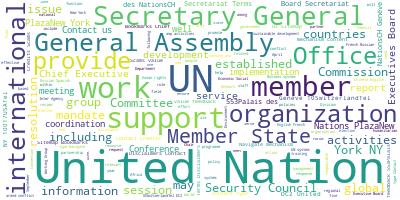

In [ ]:
# 方法一： 词云
from wordcloud import WordCloud 
long_string = ','.join(list(df['mandate_processed'].values))

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(long_string)

wordcloud.to_image()


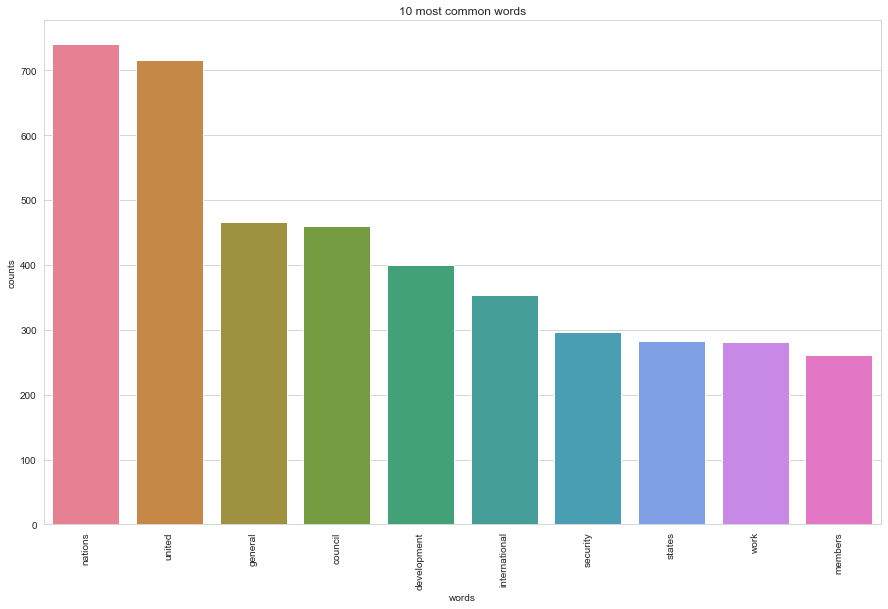

In [ ]:
# 方法二： 10 most common words 柱状图
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt #圖形可視化庫
import seaborn as sns #圖形可視化庫
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer): #count_data是文本数据转换成的词频向量的集合，count_vectorizer是用于将文本数据转换成词频向量的向量化工具
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names() #获取词汇表中的所有词汇
    total_counts = np.zeros(len(words)) #初始化一个与词汇表长度相等的数组total_counts，用于存储每个词汇的总出现次数。这里使用numpy的zeros函数创建全零数组
    for t in count_data:
        total_counts+=t.toarray()[0] #将每个词频向量t转换成数组并与total_counts进行逐元素相加。这样，total_counts最终存储了每个词汇在整个数据集中的总出现次数
    
    count_dict = (zip(words, total_counts)) #使用zip函数将词汇列表words和对应的总计数total_counts打包为一个元组列表，每个元组包含一个词汇及其总出现次数
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10] #将count_dict按照出现次数（每个元组的第二个元素）降序排序，并选取前10个最频繁出现的词汇及其次数
    words = [w[0] for w in count_dict] #从排序并筛选后的count_dict中提取前10个词汇，存储在列表words中。
    counts = [w[1] for w in count_dict] #从排序并筛选后的count_dict中提取这10个词汇的出现次数，存储在列表counts中
    x_pos = np.arange(len(words))  #从排序并筛选后的count_dict中提取这10个词汇的出现次数，存储在列表counts中
    
    #用matplotblib 做柱状图
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words 
#用来指定需要过滤掉的停用词（stop words），这里的'english'表示使用英文停用词表，即将英语中一些常用但无实际含义的单词（如a, an, the, and等）过滤掉，以减少对特征提取的干扰
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['mandate_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:
#方法3: topic modeling
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function 这个表达式的作用是从一个主题模型的单个主题中选取权重最高的n_top_words个词汇，并将它们连接成一个由空格分隔的字符串，用于显示或输出这个主题的关键词汇
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
nations united general board development contact navigate international res mechanism

Topic #1:
committee resolution council security session established united nations management 2015

Topic #2:
humanitarian ocha development global nations united countries general support people

Topic #3:
council united nations security conflict operations support statistical general peacekeeping

Topic #4:
nations electoral united development activities international general member mandate members


In [ ]:
#以下不用看
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

IndentationError: expected an indented block (<unknown>, line 8)

In [ ]:
#  
import spacy #for 文本分析
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

import nltk #natural language toolkit 自然语言处理
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)


In [ ]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

In [ ]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens